In [2]:
!python --version
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Final Project/Justin Zhang Final Project"
path_current = "/content/drive/MyDrive/Colab Notebooks/Final Project/Justin Zhang Final Project"
# %cd "/content/drive/SharedwithMe/Final Project Submission/Justin Zhang_112615200/Justin Zhang Final Project"
# path_current = "/content/drive/SharedwithMe/Final Project Submission/Justin Zhang_112615200/Justin Zhang Final Project"

Python 3.7.13
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Final Project/Justin Zhang Final Project


In [3]:
!apt-get update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!pip install gym[atari]
!pip install pybullet
# !pip install gym[all]


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [748 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports In

In [4]:
!git clone https://github.com/benelot/pybullet-gym.git

fatal: destination path 'pybullet-gym' already exists and is not an empty directory.


In [5]:
cd ./pybullet-gym/

/content/drive/MyDrive/Colab Notebooks/Final Project/Justin Zhang Final Project/pybullet-gym


In [6]:
!pip install -e .
!pip install gym[atari,accept-rom-license]==0.21.0
!pip install opencv-python
!pip install --user gym

Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/Final%20Project/Justin%20Zhang%20Final%20Project/pybullet-gym
  Running setup.py develop for pybulletgym
     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 34.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=152a5f3cb274205ff953adceeab656da1d4c6f698de3a6690ec0a1aa43096b98
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=e793a47d849ba5719cc10c90ea483d72f6f6519e83fa227c80e3b2ff5746e6b5
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-li

## Import everything
This should be the place where you import all required packages.

In [7]:
import gym
import gym.spaces
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import pybulletgym  # register PyBullet enviroments with open ai gym
import pybullet
import pybullet_data
import cv2
import copy
import numpy as np
from numpy.random import randint
# from random import random
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from collections import namedtuple, deque
import collections
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

# Colab comes with PyTorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

False


#Inverted pendulum

In [8]:
actionSpace = [-1.0, -0.9, -0.8,-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#bservation space of (210, 160, 3)
ENV_NAME = "InvertedPendulumMuJoCoEnv-v0"
env = gym.make(ENV_NAME)

In [10]:
env.reset()
state = env.render(mode='rgb_array')
print(state.shape)

(240, 320, 3)


##Replay Buffer

In [ ]:
entry = namedtuple ('entry', field_names = ['state', 'action', 'reward', 'done', 'nextstate'])

def unzip(iterable):
    return zip(*iterable)

class ReplayBuffer:
  def __init__(self, size):
    self.buf = deque(maxlen = size)
  def sample(self, size):
    temp = np.random.choice(len(self.buf), size, replace=False)
    chosen = [self.buf[i] for i in temp]
    state, actions, reward, done, nextState = unzip(chosen)
    return np.array(state,dtype=np.float32), np.array(actions), np.array(reward,dtype=np.float32), np.array(done, dtype=np.uint8), np.array(nextState,dtype=np.float32)
  def add(self, sample):
    self.buf.append(sample)
  def size(self):
    return len(self.buf)

##Reward Discounter Function, Gray scale, and Resize Functons

In [ ]:
#rewards = list of rewards
def discountReward(rewards, gamma=0.99):
    #discount the rewards
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
    #this normalizes the rewards
    r = r[::-1].cumsum()[::-1] 
    # return r
    return np.subtract(r, r.mean())

#img = a 3D array representing am img with rgb values
def toGray(img):
  rgb_weights = [0.2989, 0.5870, 0.1140]
  return np.dot(img[...,:3], rgb_weights)

#img = gray scaled img
def resize(img):
  return cv2.resize(img, (50,50))

def resizeAndGray(img):
  return resize(toGray(img))

##Neural Net Designs

###CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self, algName=None):
    self.algName = algName
    super(CNN, self).__init__()
    #the convolution layers
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    #the init to determine shape between convolution and fully connected
    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self.toLin = None
    self.convs(x)
    #The fully connected layer
    self.fc1 = nn.Linear(self.toLin, 256)
    self.fc2 = nn.Linear(256, 21)
    #some useful things
    self.softMax = nn.Softmax()

  def convs (self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2,stride=2)
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2,stride=2)
    if self.toLin is None:
      self.toLin = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  def forward(self, x):
    x = self.convs(x)
    x = x.reshape(-1, self.toLin)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    if self.algName is "REINFORCE":
      return self.softMax(x)
    return x
  def setReinforce(self):
    self.algName = "REINFORCE"
    
##Code to test the cnn and see if it works

# temp = CNN("REINFORCE")
# state = env.reset()
# grayState = toGray(state)
# grayState = cv2.resize(grayState, (50,50))
# stateTensor = torch.FloatTensor(grayState)
# test = temp(stateTensor.view(-1, 1, 50, 50))
# print(test)

###FNN

In [ ]:
class FNN(nn.Module):
  def __init__(self, algName = None):
    super(FNN, self).__init__()
    self.algName = algName
    self.fc1 = nn.Linear(50*50, 100) 
    self.fc2 = nn.Linear(100, 64) 
    self.fc3 = nn.Linear(64, 21)#21 total discrete actions
    self.softMax = nn.Softmax(dim=-1)
  def forward(self, x):
        # x = x.view(-1, 50*50)#flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if self.algName is "REINFORCE":
          return self.softMax(x)
        return x
  def setReinforce(self):
    self.algName = "REINFORCE"

##Code to test the fnn and see if it works

# temp = FNN("REINFORCE")
# state = env.reset()
# grayState = toGray(state)
# grayState = cv2.resize(grayState, (50,50))
# stateTensor = torch.FloatTensor(grayState)
# test = temp(stateTensor)
# print(test)


##REINFORCE

###Algorithm

####FNN

In [ ]:
fnnReinforce = FNN("REINFORCE")

In [ ]:
NumEpisodes = 2000
batchSize = 10
gamma = 0.90

epsilon = 0.1

totalRewardRfnn = []
RLossFnn=[]
batchedRewards = []
batchedStates = []
batchedActions = []
batchedCount = 1
# actions = np.arange(env.action_space.n)
optimizer = optim.Adam(fnnReinforce.parameters(), lr=0.00002)
episodeCount = 0

while episodeCount < NumEpisodes:
  #reset the environment and temp lists
  state = env.reset()
  #for batching
  statesList = []
  rewardsList = []
  actionsList = []
  done = False
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state).flatten()
    stateTensor = torch.FloatTensor(grayState)
    probs = fnnReinforce(stateTensor).detach().numpy()
    #generate a random choice based on "probabilities" form net
    action = np.random.choice(actionSpace, p=probs) 
    statesList.append(grayState)
    state, reward, done, _ = env.step([action])
    rewardsList.append(reward)
    actionsList.append(action)
  #The episode should be done now
  batchedRewards.extend(discountReward(rewardsList, gamma))
  batchedActions.extend(actionsList)
  batchedStates.extend(statesList)
  totalRewardRfnn.append(sum(rewardsList))
  batchedCount += 1
  #if the number batched then start to find loss
  if batchedCount == batchSize: 
    #now do the loss and back prop
    optimizer.zero_grad()
    stateBatchTensor=torch.FloatTensor(batchedStates)
    rewardBatchTensor = torch.FloatTensor(batchedRewards)
    # get index array for actions
    indexList = []
    for action in batchedActions:
      indexList.append(actionSpace.index(action))
    #calc loss and backprop
    temp = fnnReinforce(stateBatchTensor)
    logOut = torch.log(temp)
    print(logOut)
    temp = torch.gather(logOut, 1, torch.LongTensor(indexList).unsqueeze(-1)).squeeze()
    selectedLogOut = rewardBatchTensor * temp
    loss = -selectedLogOut.mean()
    RLossFnn.append(loss)
    loss.backward()
    optimizer.step()
    batchedRewards = []
    batchedStates = []
    batchedActions = []
    batchedCount = 1
    print(f'Episode:{episodeCount} Loss:{loss}')
  episodeCount+=1

tensor([[-60.4068, -36.4578, -26.4764,  ..., -25.4111, -82.9780, -50.7250],
        [-60.4639, -36.4340, -26.4781,  ..., -25.4609, -83.0128, -50.8026],
        [-60.4632, -36.4312, -26.4790,  ..., -25.4595, -83.0139, -50.8073],
        ...,
        [-61.3150, -35.7897, -27.6976,  ..., -25.7529, -84.5279, -52.5699],
        [-61.3110, -35.7351, -27.7215,  ..., -25.6988, -84.5444, -52.6169],
        [-60.8715, -35.5174, -27.2998,  ..., -25.6244, -84.2818, -52.5075]],
       grad_fn=<LogBackward0>)
Episode:8 Loss:-0.0
tensor([[-60.4628, -36.4259, -26.5004,  ..., -25.5737, -83.0373, -50.7429],
        [-60.4784, -36.4190, -26.5011,  ..., -25.5875, -83.0463, -50.7642],
        [-60.4803, -36.4167, -26.5043,  ..., -25.5888, -83.0502, -50.7722],
        ...,
        [-60.9516, -36.6603, -26.8631,  ..., -25.9538, -83.4881, -51.2996],
        [-60.9459, -36.6531, -26.8704,  ..., -25.9510, -83.4854, -51.3167],
        [-60.8278, -36.6778, -26.6183,  ..., -25.7903, -83.3934, -51.2724]],
       gr

#####Save Neural Net

In [ ]:
# torch.save(fnnReinforce, "fnnReinforce.pth")
# torch.save(totalRewardRfnn, "totalRewardRfnn.pth")

#####Load Neural Net

In [ ]:
fnnReinforce = torch.load("fnnReinforce.pth")
totalRewardRfnn = torch.load("totalRewardRfnn.pth")
fnnReinforce.setReinforce()

####CNN

In [ ]:
cnnReinforce = CNN("REINFORCE")

In [ ]:
NumEpisodes = 2000
batchSize = 10
gamma = 0.99

totalRewardRcnn = []
batchedRewards = []
batchedStates = []
batchedActions = []
batchedCount = 1
# actions = np.arange(env.action_space.n)
optimizer = optim.Adam(cnnReinforce.parameters(), lr=0.0005)
episodeCount = 0

while episodeCount < NumEpisodes:
  #reset the environment and temp lists
  state = env.reset()
  #for batching
  statesList = []
  rewardsList = []
  actionsList = []
  done = False
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    grayState = resizeAndGray(state)
    stateTensor = torch.FloatTensor(grayState)
    probs = cnnReinforce(stateTensor.view(-1,1,50,50).to(device)).cpu().detach().numpy()[0]
    #generate a random choice based on "probabilities" form net
    # print(probs)
    action = np.random.choice(actionSpace, p=probs) 
    #step forward in environment
    # print(state)

    statesList.append(grayState)
    state, reward, done, _ = env.step([action])
    
    rewardsList.append(reward)
    actionsList.append(action)
  # print("episodeDone")
  #The episode should be done now
  batchedRewards.extend(discountReward(rewardsList, gamma))
  batchedActions.extend(actionsList)
  batchedStates.extend(statesList)
  totalRewardRcnn.append(sum(rewardsList))
  batchedCount += 1
  #if the number batched then start to find loss
  # print(f'count{batchCount} size{batchSize}')
  if batchedCount == batchSize: 
    #now do the loss and back prop
    optimizer.zero_grad()
    stateBatchTensor=torch.FloatTensor(batchedStates)
    stateBatchShape = stateBatchTensor.shape[0]
    rewardBatchTensor = torch.FloatTensor(batchedRewards) - (sum(batchedRewards)/stateBatchShape)
    
    # print(stateBatchTensor.shape[0])
    # get index array for actions
    indexList = []
    for action in batchedActions:
      indexList.append(actionSpace.index(action))
    # calc loss and backprop
    # print(stateBatchTensor.shape)
    TEMP = stateBatchTensor.view(stateBatchShape, 1, 50, 50)
    # print(stateBatchTensor)
    # print(TEMP)
    logOut = torch.log(cnnReinforce(stateBatchTensor.view(stateBatchShape, 1, 50, 50 ).to(device)))
    # print(logOut)
    temp = torch.gather(logOut, 1, torch.LongTensor(indexList).to(device).unsqueeze(-1)).squeeze()
    selectedLogOut = rewardBatchTensor.to(device) * temp
    # print(selectedLogOut)
    loss = -selectedLogOut.mean()
    # print(loss)
    loss.backward()
    optimizer.step()
    batchedRewards = []
    batchedStates = []
    batchedActions = []
    batchedCount = 1
    print(f'Episode:{episodeCount} Loss:{loss}')
  episodeCount+=1
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode:8 Loss:-0.007450408767908812
Episode:17 Loss:0.04245892912149429
Episode:26 Loss:-0.02046552486717701
Episode:35 Loss:-0.05160136893391609
Episode:44 Loss:-0.0018670945428311825
Episode:53 Loss:0.06120842695236206
Episode:62 Loss:-0.022589972242712975
Episode:71 Loss:-0.03693747520446777
Episode:80 Loss:0.023758934810757637
Episode:89 Loss:-0.1082199290394783
Episode:98 Loss:-0.06470805406570435
Episode:107 Loss:0.04366237670183182
Episode:116 Loss:-0.07807188481092453
Episode:125 Loss:0.10206469148397446
Episode:134 Loss:0.14893101155757904
Episode:143 Loss:0.1318700760602951
Episode:152 Loss:-0.004149688873440027
Episode:161 Loss:-0.026037797331809998
Episode:170 Loss:0.058155607432127
Episode:179 Loss:0.13588429987430573
Episode:188 Loss:0.008245328441262245
Episode:197 Loss:0.024906612932682037
Episode:206 Loss:-0.09365362673997879
Episode:215 Loss:0.11943139880895615
Episode:224 Loss:0.057488977909088135
Episode:233 Loss:-0.05087292939424515
Episode:242 Loss:0.011788530275

#####Save Neural Net

In [ ]:
# torch.save(cnnReinforce, "cnnReinforce.pth")
# torch.save(totalRewardRcnn, "totalRewardRcnn.pth")

#####Load NeuralNet

In [ ]:
cnnReinforce = torch.load("cnnReinforce.pth")
totalRewardRcnn = torch.load("totalRewardRcnn.pth")
# print(totalRewardRcnn)
cnnReinforce.setReinforce()

###Graph 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  # This is added back by InteractiveShellApp.init_path()


<function matplotlib.pyplot.show>

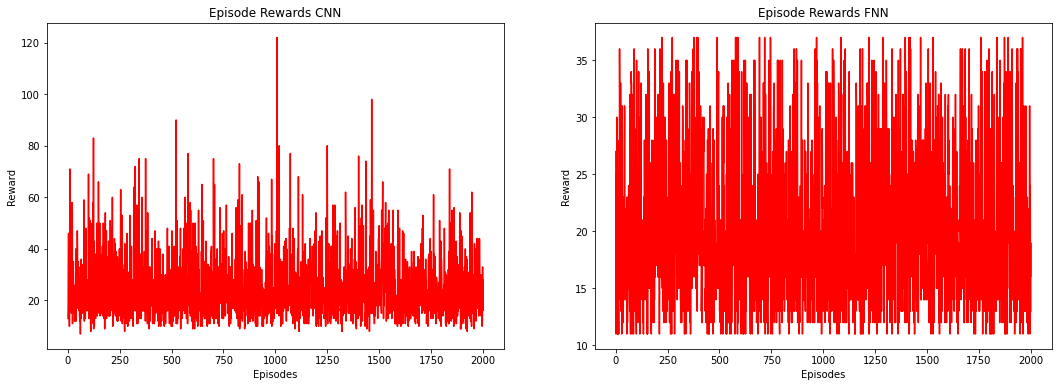

In [ ]:
"""
draw all useful graphs such as episodes vs reward.
"""
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
# totalRewardRfnn = [0 for i in range(1000)]
episodeListscnn = [i+1 for i in range(len(totalRewardRcnn))]
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Rewards CNN')
plt.plot(episodeListscnn, totalRewardRcnn, "R")

plt.subplot(1, 2, 2)
# totalRewardRfnn = [0 for i in range(1000)]
episodeListsfnn = [i+1 for i in range(len(totalRewardRfnn))]
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Rewards FNN')
plt.plot(episodeListsfnn, totalRewardRfnn, "R")
plt.show

###Evaluation/Testing

####FNN

In [ ]:
episodeCount = 0
rewardList = []
while episodeCount < 10:
  #reset the environment 
  state = env.reset()
  done = False
  epreward = 0
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state).flatten()
    stateTensor = torch.FloatTensor(grayState)
    # print(stateTensor.shape)
    probs = fnnReinforce(stateTensor).detach().numpy()
    # print(probs)
    #generate a random choice based on "probabilities" form net
    action = np.random.choice(actionSpace, p=probs) 
    #step forward in environment
    # statesList.append(state)
    state, reward, done, _ = env.step([action])
    epreward += reward
  print(f'Episode: {episodeCount+1} Reward: {epreward}')
  rewardList.append(epreward)
  episodeCount+=1
print(f'Average reward across the 10 episodes: {sum(rewardList)/10}')

Episode: 1 Reward: 13.0
Episode: 2 Reward: 17.0
Episode: 3 Reward: 12.0
Episode: 4 Reward: 14.0
Episode: 5 Reward: 15.0
Episode: 6 Reward: 34.0
Episode: 7 Reward: 31.0
Episode: 8 Reward: 27.0
Episode: 9 Reward: 22.0
Episode: 10 Reward: 31.0
Average reward across the 10 episodes: 21.6


####CNN

In [ ]:
episodeCount = 0
rewardList = []
while episodeCount < 10:
  #reset the environment 
  state = env.reset()
  done = False
  epreward = 0
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state)
    stateTensor = torch.FloatTensor(grayState).to(device).view(1, -1, 50, 50)
    # print(stateTensor.shape)
    probs = cnnReinforce(stateTensor).cpu().detach().numpy()
    # print(probs)
    #generate a random choice based on "probabilities" form net
    action = np.random.choice(actionSpace, p=probs[0]) 
    #step forward in environment
    # statesList.append(state)
    state, reward, done, _ = env.step([action])
    epreward += reward
  print(f'Episode: {episodeCount+1} Reward: {epreward}')
  rewardList.append(epreward)
  episodeCount+=1
print(f'Average reward across the 10 episodes: {sum(rewardList)/10}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode: 1 Reward: 8.0
Episode: 2 Reward: 15.0
Episode: 3 Reward: 14.0
Episode: 4 Reward: 13.0
Episode: 5 Reward: 9.0
Episode: 6 Reward: 15.0
Episode: 7 Reward: 8.0
Episode: 8 Reward: 9.0
Episode: 9 Reward: 12.0
Episode: 10 Reward: 11.0
Average reward across the 10 episodes: 11.4


##FQI


###Algorithm

####FNN

In [ ]:
targetModelfnn = FNN()
currentModelfnn = FNN()

In [ ]:
optimizer = optim.Adam(currentModelfnn.parameters(), lr=0.01)
citerion = nn.MSELoss()

gamma = 0.99
totalEpisodes = 800
epsilon = 1
decay = 0.999
minE = 0.08

replayBuffer = ReplayBuffer(10000)
batchsize = 32
batchLoop = 3
FQIfnnrewards = []
FQIfnnloss = []
curEp = 0
while curEp < totalEpisodes:
  state = env.reset()
  done = False
  tempReward = []
  while not done:
    grayState = resizeAndGray(state).flatten()
    rand = random.uniform(0,1)
    #take egreedy action
    if rand > epsilon:
      stateTensor = torch.FloatTensor(grayState)
      largestIndex = torch.argmax(currentModelfnn(stateTensor))
      action = [actionSpace[largestIndex]]
    else:
      randInt = randint(0, 20)
      action = [actionSpace[randInt]]
    state, reward, done, _ = env.step(action)
    grayfutureState = resizeAndGray(state).flatten()
    newEntry = entry(grayState, action, reward, done, grayfutureState) 
    replayBuffer.add(newEntry)
    tempReward.append(reward)

    epsilon *= decay
    if epsilon< minE:
      epsilon = minE


    targetModelfnn.load_state_dict(currentModelfnn.state_dict())
    #training loop
    if(replayBuffer.size() > 2*batchSize):
      for i in range(batchLoop):
        stateArr, actionArr, rewardArr, doneArr, nextArr = replayBuffer.sample(batchSize)
        stateTensor = torch.FloatTensor(stateArr)
        # actionTensor = torch.FloatTensor(actionArr)
        rewardTensor = torch.FloatTensor(rewardArr)
        doneTensor = torch.ByteTensor(doneArr)
        nextTensor = torch.FloatTensor(nextArr)
        stateShape = stateArr.shape[0]
        curStateOut = currentModelfnn(stateTensor)
        # print(curStateOut)
        #get the indexes for actions
        indexList = []
        for action in actionArr:
          indexList.append(actionSpace.index(action))
        estimate = curStateOut.gather(1, torch.LongTensor(indexList).unsqueeze(-1)).squeeze(-1)
        # print(estimate)
        nextShape = stateArr.shape[0]
        targetVal = targetModelfnn(nextTensor).max(1)[0]
        targetVal[doneTensor] = float(0)
        targetValue = targetVal * gamma + rewardTensor
        loss = citerion(estimate, targetValue)
        FQIfnnloss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  print(f'Episode:{curEp}, reward:{sum(tempReward)}')
  FQIfnnrewards.append(sum(tempReward))
  curEp+=1

Episode:0, reward:22.0
Episode:1, reward:25.0
Episode:2, reward:18.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1391.)
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1391.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Episode:3, reward:14.0
Episode:4, reward:19.0
Episode:5, reward:57.0
Episode:6, reward:25.0
Episode:7, reward:15.0
Episode:8, reward:35.0
Episode:9, reward:14.0
Episode:10, reward:46.0
Episode:11, reward:20.0
Episode:12, reward:18.0
Episode:13, reward:30.0
Episode:14, reward:27.0
Episode:15, reward:23.0
Episode:16, reward:19.0
Episode:17, reward:16.0
Episode:18, reward:14.0
Episode:19, reward:32.0
Episode:20, reward:15.0
Episode:21, reward:12.0
Episode:22, reward:56.0
Episode:23, reward:22.0
Episode:24, reward:22.0
Episode:25, reward:15.0
Episode:26, reward:25.0
Episode:27, reward:15.0
Episode:28, reward:13.0
Episode:29, reward:13.0
Episode:30, reward:13.0
Episode:31, reward:11.0
Episode:32, reward:20.0
Episode:33, reward:20.0
Episode:34, reward:16.0
Episode:35, reward:18.0
Episode:36, reward:17.0
Episode:37, reward:11.0
Episode:38, reward:16.0
Episode:39, reward:11.0
Episode:40, reward:14.0
Episode:41, reward:15.0
Episode:42, reward:15.0
Episode:43, reward:14.0
Episode:44, reward:20.0

#####Save Neural Net

In [ ]:
# torch.save(currentModelfnn, "currentModelfnn.pth")
# torch.save(FQIfnnrewards, "FQIfnnrewards.pth")
# torch.save(FQIfnnloss, "FQIfnnloss.pth")

#####Load Neural Net

In [ ]:
currentModelfnn = torch.load("currentModelfnn.pth")
FQIfnnrewards = torch.load("FQIfnnrewards.pth")
FQIfnnloss =torch.load("FQIfnnloss.pth")

####CNN

In [ ]:
targetModelcnn = CNN()
currentModelcnn = CNN()

In [ ]:
optimizer = optim.Adam(currentModelcnn.parameters(), lr=0.01)
citerion = nn.MSELoss()

gamma = 0.99
totalEpisodes = 1600
epsilon = 1
decay = 0.999
minE = 0.08

replayBuffer = ReplayBuffer(10000)
batchSize = 32
batchLoop = 3
FQIcnnrewards = []
FQIcnnloss = []
curEp = 0
while curEp < totalEpisodes:
  state = env.reset()
  done = False
  tempReward = []
  while not done:
    grayState = resizeAndGray(state)
    rand = random.uniform(0,1)
    #take egreedy action
    if rand > epsilon:
      stateTensor = torch.FloatTensor(grayState)
      largestIndex = torch.argmax(currentModelcnn(stateTensor.view(-1,1,50,50).to(device)))
      action = [actionSpace[largestIndex]]
    else:
      randInt = randint(0, 20)
      action = [actionSpace[randInt]]
    state, reward, done, _ = env.step(action)
    grayfutureState = resizeAndGray(state)
    newEntry = entry(grayState, action, reward, done, grayfutureState) 
    replayBuffer.add(newEntry)
    tempReward.append(reward)

    epsilon *= decay
    if epsilon< minE:
      epsilon = minE


    targetModelcnn.load_state_dict(currentModelcnn.state_dict())
    #training loop
    if(replayBuffer.size() > 2*batchSize):
      for i in range(batchLoop):
        stateArr, actionArr, rewardArr, doneArr, nextArr = replayBuffer.sample(batchSize)
        stateTensor = torch.FloatTensor(stateArr)
        # actionTensor = torch.FloatTensor(actionArr)
        rewardTensor = torch.FloatTensor(rewardArr)
        doneTensor = torch.ByteTensor(doneArr)
        nextTensor = torch.FloatTensor(nextArr)
        stateShape = stateArr.shape[0]
        curStateOut = currentModelcnn(stateTensor.view(stateShape, 1, 50, 50).to(device)).cpu()
        # print(curStateOut)
        #get the indexes for actions
        indexList = []
        for action in actionArr:
          indexList.append(actionSpace.index(action))
        estimate = curStateOut.gather(1, torch.LongTensor(indexList).unsqueeze(-1)).squeeze(-1)
        # print(estimate)
        nextShape = stateArr.shape[0]
        targetVal = targetModelcnn(nextTensor.view(nextShape, 1, 50, 50).to(device)).max(1)[0]
        targetVal[doneTensor] = float(0)
        targetValue = targetVal.cpu() * gamma + rewardTensor
        loss = citerion(estimate, targetValue)
        FQIcnnloss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  print(f'Episode:{curEp}, reward:{sum(tempReward)}')
  FQIcnnrewards.append(sum(tempReward))
  curEp+=1

Episode:0, reward:41.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Episode:1, reward:29.0
Episode:2, reward:20.0
Episode:3, reward:12.0
Episode:4, reward:18.0
Episode:5, reward:12.0
Episode:6, reward:16.0
Episode:7, reward:26.0
Episode:8, reward:10.0
Episode:9, reward:15.0
Episode:10, reward:14.0
Episode:11, reward:16.0
Episode:12, reward:26.0
Episode:13, reward:20.0
Episode:14, reward:16.0
Episode:15, reward:22.0
Episode:16, reward:20.0
Episode:17, reward:22.0
Episode:18, reward:28.0
Episode:19, reward:42.0
Episode:20, reward:10.0
Episode:21, reward:18.0
Episode:22, reward:11.0
Episode:23, reward:16.0
Episode:24, reward:13.0
Episode:25, reward:13.0
Episode:26, reward:10.0
Episode:27, reward:9.0
Episode:28, reward:11.0
Episode:29, reward:17.0
Episode:30, reward:13.0
Episode:31, reward:26.0
Episode:32, reward:14.0
Episode:33, reward:23.0
Episode:34, reward:17.0
Episode:35, reward:10.0
Episode:36, reward:20.0
Episode:37, reward:21.0
Episode:38, reward:16.0
Episode:39, reward:25.0
Episode:40, reward:13.0
Episode:41, reward:19.0
Episode:42, reward:29.0
Ep

#####Save Neural Net

In [ ]:
# torch.save(currentModelcnn, "currentModelcnn.pth")
# torch.save(FQIcnnrewards, "FQIcnnrewards.pth")
# torch.save(FQIcnnloss, "FQIcnnloss.pth")

#####Load Neural Net

In [ ]:
currentModelcnn = torch.load("currentModelcnn.pth", map_location=torch.device('cpu'))
FQIcnnrewards = torch.load("FQIcnnrewards.pth")
FQIcnnloss = torch.load("FQIcnnloss.pth")

####Graph

<function matplotlib.pyplot.show>

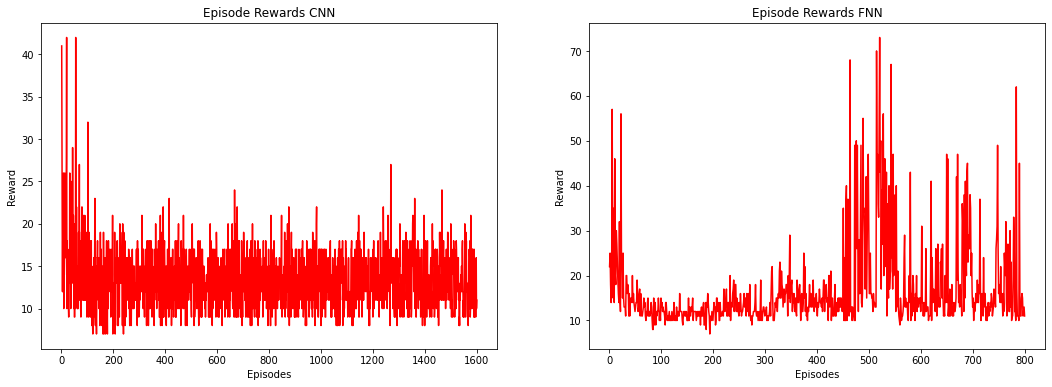

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
episodeListscnn = [i+1 for i in range(len(FQIcnnrewards))]
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Rewards CNN')
plt.plot(episodeListscnn, FQIcnnrewards, "R")

plt.subplot(1, 2, 2)
episodeListsfnn = [i+1 for i in range(len(FQIfnnrewards))]
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Rewards FNN')
plt.plot(episodeListsfnn, FQIfnnrewards, "R")
plt.show

####Evaluation/Testing

#####FNN

In [ ]:
episodeCount = 0
rewardList = []
while episodeCount < 10:
  #reset the environment 
  state = env.reset()
  done = False
  epreward = 0
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state).flatten()
    stateTensor = torch.FloatTensor(grayState)
    # print(stateTensor.shape)
    index = torch.argmax(currentModelfnn(stateTensor))
    # print(probs)
    #generate a random choice based on "probabilities" form net
    action = actionSpace[index]
    #step forward in environment
    # statesList.append(state)
    state, reward, done, _ = env.step([action])
    epreward += reward
  print(f'Episode: {episodeCount+1} Reward: {epreward}')
  rewardList.append(epreward)
  episodeCount+=1
print(f'Average reward across the 10 episodes: {sum(rewardList)/10}')

Episode: 1 Reward: 9.0
Episode: 2 Reward: 9.0
Episode: 3 Reward: 9.0
Episode: 4 Reward: 12.0
Episode: 5 Reward: 7.0
Episode: 6 Reward: 12.0
Episode: 7 Reward: 8.0
Episode: 8 Reward: 7.0
Episode: 9 Reward: 8.0
Episode: 10 Reward: 7.0
Average reward across the 10 episodes: 8.8


#####CNN

In [ ]:
episodeCount = 0
rewardList = []
while episodeCount < 10:
  #reset the environment 
  state = env.reset()
  done = False
  epreward = 0
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state)
    stateTensor = torch.FloatTensor(grayState).view(-1, 1, 50, 50)
    # print(stateTensor.shape)
    index = torch.argmax(currentModelcnn(stateTensor))
    # print(probs)
    #generate a random choice based on "probabilities" form net
    action = actionSpace[index]
    #step forward in environment
    # statesList.append(state)
    state, reward, done, _ = env.step([action])
    epreward += reward
  print(f'Episode: {episodeCount+1} Reward: {epreward}')
  rewardList.append(epreward)
  episodeCount+=1
print(f'Average reward across the 10 episodes: {sum(rewardList)/10}')

Episode: 1 Reward: 16.0
Episode: 2 Reward: 11.0
Episode: 3 Reward: 8.0
Episode: 4 Reward: 17.0
Episode: 5 Reward: 8.0
Episode: 6 Reward: 12.0
Episode: 7 Reward: 16.0
Episode: 8 Reward: 11.0
Episode: 9 Reward: 18.0
Episode: 10 Reward: 11.0
Average reward across the 10 episodes: 12.8


##DQN

###Algorithm

####FNN

In [ ]:
targetModelDQNfnn = FNN()
currentModelDQNfnn = FNN()

In [ ]:
optimizer = optim.Adam(currentModelcnn.parameters(), lr=0.01)
citerion = nn.MSELoss()

gamma = 0.99
totalEpisodes = 1000
epsilon = 1
decay = 0.999
minE = 0.08

replayBuffer = ReplayBuffer(10000)
batchsize = 32
batchLoop = 3
DQNfnnrewards = []
DQNfnnloss = []
curEp = 0
while curEp < totalEpisodes:
  state = env.reset()
  done = False
  tempReward = []
  targetModelDQNfnn.load_state_dict(currentModelDQNfnn.state_dict())
  while not done:
    grayState = resizeAndGray(state).flatten()
    rand = random.uniform(0,1)
    #take egreedy action
    if rand > epsilon:
      stateTensor = torch.FloatTensor(grayState)
      largestIndex = torch.argmax(currentModelDQNfnn(stateTensor.to(device)))
      action = [actionSpace[largestIndex]]
    else:
      randInt = randint(0, 20)
      action = [actionSpace[randInt]]
    state, reward, done, _ = env.step(action)
    grayfutureState = resizeAndGray(state).flatten()
    newEntry = entry(grayState, action, reward, done, grayfutureState) 
    replayBuffer.add(newEntry)
    tempReward.append(reward)

    epsilon *= decay
    if epsilon< minE:
      epsilon = minE

    #training loop
    if(replayBuffer.size() > 2*batchSize):
      for i in range(batchLoop):
        stateArr, actionArr, rewardArr, doneArr, nextArr = replayBuffer.sample(batchSize)
        stateTensor = torch.FloatTensor(stateArr)
        # actionTensor = torch.FloatTensor(actionArr)
        rewardTensor = torch.FloatTensor(rewardArr)
        doneTensor = torch.ByteTensor(doneArr)
        nextTensor = torch.FloatTensor(nextArr)
        stateShape = stateArr.shape[0]
        curStateOut = currentModelDQNfnn(stateTensor.to(device)).cpu()
        # print(curStateOut)
        #get the indexes for actions
        indexList = []
        for action in actionArr:
          indexList.append(actionSpace.index(action))
        estimate = curStateOut.gather(1, torch.LongTensor(indexList).unsqueeze(-1)).squeeze(-1)
        # print(estimate)
        nextShape = stateArr.shape[0]
        targetVal = targetModelDQNfnn(nextTensor.to(device)).max(1)[0]
        targetVal[doneTensor] = float(0)
        targetValue = targetVal.cpu() * gamma + rewardTensor
        loss = citerion(targetValue, estimate)
        DQNfnnloss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  print(f'Episode:{curEp}, reward:{sum(tempReward)}')
  DQNfnnrewards.append(sum(tempReward))
  curEp+=1

Episode:0, reward:51.0
Episode:1, reward:16.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Episode:2, reward:42.0
Episode:3, reward:17.0
Episode:4, reward:20.0
Episode:5, reward:9.0
Episode:6, reward:28.0
Episode:7, reward:13.0
Episode:8, reward:30.0
Episode:9, reward:25.0
Episode:10, reward:20.0
Episode:11, reward:29.0
Episode:12, reward:17.0
Episode:13, reward:22.0
Episode:14, reward:37.0
Episode:15, reward:18.0
Episode:16, reward:26.0
Episode:17, reward:32.0
Episode:18, reward:21.0
Episode:19, reward:41.0
Episode:20, reward:32.0
Episode:21, reward:16.0
Episode:22, reward:28.0
Episode:23, reward:15.0
Episode:24, reward:18.0
Episode:25, reward:16.0
Episode:26, reward:44.0
Episode:27, reward:17.0
Episode:28, reward:14.0
Episode:29, reward:14.0
Episode:30, reward:13.0
Episode:31, reward:17.0
Episode:32, reward:74.0
Episode:33, reward:33.0
Episode:34, reward:10.0
Episode:35, reward:31.0
Episode:36, reward:20.0
Episode:37, reward:29.0
Episode:38, reward:19.0
Episode:39, reward:24.0
Episode:40, reward:29.0
Episode:41, reward:19.0
Episode:42, reward:16.0
Episode:43, reward:37.0
E

#####Save Neural Net

In [ ]:
# torch.save(currentModelDQNfnn, "currentModelDQNfnn.pth")
# torch.save(DQNfnnrewards, "DQNfnnrewards.pth")
# torch.save(DQNfnnloss, "DQNfnnloss.pth")

#####Load Neural Net

In [ ]:
currentModelDQNfnn = torch.load("currentModelDQNfnn.pth", map_location=torch.device('cpu'))
DQNfnnrewards = torch.load("DQNfnnrewards.pth")
DQNfnnloss= torch.load("DQNfnnloss.pth")

####CNN

In [ ]:
targetModelDQNcnn = CNN()
currentModelDQNcnn = CNN()

In [ ]:
optimizer = optim.Adam(currentModelcnn.parameters(), lr=0.01)
citerion = nn.MSELoss()

gamma = 0.99
totalEpisodes = 1000
epsilon = 1
decay = 0.999
minE = 0.08

replayBuffer = ReplayBuffer(10000)
batchsize = 32
batchLoop = 3
DQNcnnrewards = []
DQNcnnloss = []
curEp = 0
while curEp < totalEpisodes:
  state = env.reset()
  done = False
  tempReward = []
  targetModelDQNcnn.load_state_dict(currentModelDQNcnn.state_dict())
  while not done:
    grayState = resizeAndGray(state)
    rand = random.uniform(0,1)
    #take egreedy action
    if rand > epsilon:
      stateTensor = torch.FloatTensor(grayState)
      largestIndex = torch.argmax(currentModelDQNcnn(stateTensor.view(-1,1,50,50).to(device)))
      action = [actionSpace[largestIndex]]
    else:
      randInt = randint(0, 20)
      action = [actionSpace[randInt]]
    state, reward, done, _ = env.step(action)
    grayfutureState = resizeAndGray(state)
    newEntry = entry(grayState, action, reward, done, grayfutureState) 
    replayBuffer.add(newEntry)
    tempReward.append(reward)

    epsilon *= decay
    if epsilon< minE:
      epsilon = minE

    #training loop
    if(replayBuffer.size() > 2*batchSize):
      for i in range(batchLoop):
        stateArr, actionArr, rewardArr, doneArr, nextArr = replayBuffer.sample(batchSize)
        stateTensor = torch.FloatTensor(stateArr)
        # actionTensor = torch.FloatTensor(actionArr)
        rewardTensor = torch.FloatTensor(rewardArr)
        doneTensor = torch.ByteTensor(doneArr)
        nextTensor = torch.FloatTensor(nextArr)
        stateShape = stateArr.shape[0]
        curStateOut = currentModelDQNcnn(stateTensor.view(stateShape, 1, 50, 50).to(device)).cpu()
        # print(curStateOut)
        #get the indexes for actions
        indexList = []
        for action in actionArr:
          indexList.append(actionSpace.index(action))
        estimate = curStateOut.gather(1, torch.LongTensor(indexList).unsqueeze(-1)).squeeze(-1)
        # print(estimate)
        nextShape = stateArr.shape[0]
        targetVal = targetModelDQNcnn(nextTensor.view(nextShape, 1, 50, 50).to(device)).max(1)[0]
        targetVal[doneTensor] = float(0)
        targetValue = targetVal.cpu() * gamma + rewardTensor
        loss = citerion(targetValue, estimate)
        DQNcnnloss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  print(f'Episode:{curEp}, reward:{sum(tempReward)}')
  DQNcnnrewards.append(sum(tempReward))
  curEp+=1

Episode:0, reward:20.0
Episode:1, reward:35.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Episode:2, reward:28.0
Episode:3, reward:19.0
Episode:4, reward:27.0
Episode:5, reward:43.0
Episode:6, reward:20.0
Episode:7, reward:8.0
Episode:8, reward:31.0
Episode:9, reward:19.0
Episode:10, reward:21.0
Episode:11, reward:18.0
Episode:12, reward:24.0
Episode:13, reward:23.0
Episode:14, reward:16.0
Episode:15, reward:14.0
Episode:16, reward:21.0
Episode:17, reward:13.0
Episode:18, reward:19.0
Episode:19, reward:12.0
Episode:20, reward:13.0
Episode:21, reward:13.0
Episode:22, reward:15.0
Episode:23, reward:7.0
Episode:24, reward:12.0
Episode:25, reward:20.0
Episode:26, reward:14.0
Episode:27, reward:16.0
Episode:28, reward:10.0
Episode:29, reward:12.0
Episode:30, reward:24.0
Episode:31, reward:8.0
Episode:32, reward:12.0
Episode:33, reward:13.0
Episode:34, reward:11.0
Episode:35, reward:17.0
Episode:36, reward:21.0
Episode:37, reward:9.0
Episode:38, reward:21.0
Episode:39, reward:16.0
Episode:40, reward:10.0
Episode:41, reward:14.0
Episode:42, reward:14.0
Episode:43, reward:18.0
Epis

#####Save Neural Net

In [ ]:
# torch.save(currentModelDQNcnn, "currentModelDQNcnn.pth")
# torch.save(DQNcnnrewards, "DQNcnnrewards.pth")
# torch.save(DQNcnnloss, "DQNcnnloss.pth")

#####Load Neural Net

In [ ]:
currentModelDQNcnn = torch.load("currentModelDQNcnn.pth", map_location=torch.device('cpu'))
DQNcnnrewards = torch.load("DQNcnnrewards.pth")
DQNcnnloss = torch.load("DQNcnnloss.pth")

###Graph

<function matplotlib.pyplot.show>

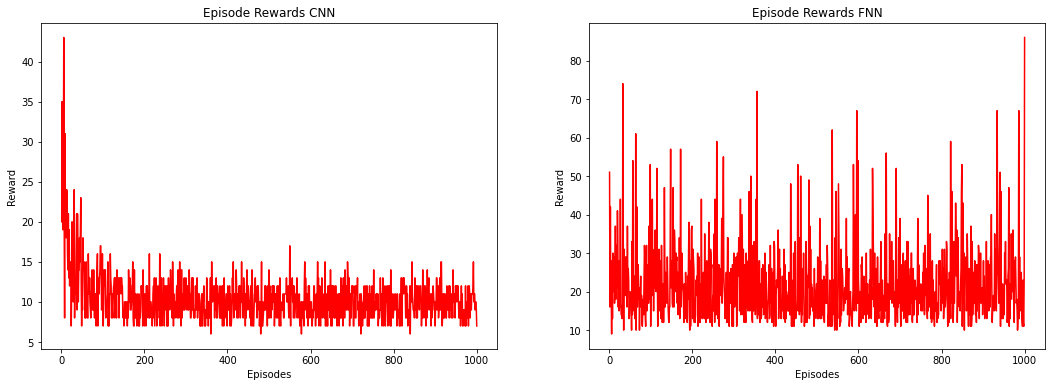

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
episodeListscnn = [i+1 for i in range(len(DQNcnnrewards))]
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Rewards CNN')
plt.plot(episodeListscnn, DQNcnnrewards, "R")

plt.subplot(1, 2, 2)
episodeListsfnn = [i+1 for i in range(len(DQNfnnrewards))]
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Rewards FNN')
plt.plot(episodeListsfnn, DQNfnnrewards, "R")
plt.show

###Evaluation/Testing

#####FNN

In [ ]:
episodeCount = 0
rewardList = []
while episodeCount < 10:
  #reset the environment 
  state = env.reset()
  done = False
  epreward = 0
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state).flatten()
    stateTensor = torch.FloatTensor(grayState)
    # print(stateTensor.shape)
    index = torch.argmax(currentModelDQNfnn(stateTensor))
    # print(probs)
    #generate a random choice based on "probabilities" form net
    action = actionSpace[index]
    #step forward in environment
    # statesList.append(state)
    state, reward, done, _ = env.step([action])
    epreward += reward
  print(f'Episode: {episodeCount+1} Reward: {epreward}')
  rewardList.append(epreward)
  episodeCount+=1
print(f'Average reward across the 10 episodes: {sum(rewardList)/10}')

Episode: 1 Reward: 9.0
Episode: 2 Reward: 14.0
Episode: 3 Reward: 9.0
Episode: 4 Reward: 14.0
Episode: 5 Reward: 13.0
Episode: 6 Reward: 9.0
Episode: 7 Reward: 12.0
Episode: 8 Reward: 13.0
Episode: 9 Reward: 10.0
Episode: 10 Reward: 13.0
Average reward across the 10 episodes: 11.6


#####CNN

In [ ]:
episodeCount = 0
rewardList = []
while episodeCount < 10:
  #reset the environment 
  state = env.reset()
  done = False
  epreward = 0
  #go through one episode
  while not done:
    # turn the current state into a tensor for the neural net
    state = env.render(mode='rgb_array')
    grayState = resizeAndGray(state)
    stateTensor = torch.FloatTensor(grayState).view(-1, 1, 50, 50)
    # print(stateTensor.shape)
    index = torch.argmax(currentModelDQNcnn(stateTensor))
    # print(probs)
    #generate a random choice based on "probabilities" form net
    action = actionSpace[index]
    #step forward in environment
    # statesList.append(state)
    state, reward, done, _ = env.step([action])
    epreward += reward
  print(f'Episode: {episodeCount+1} Reward: {epreward}')
  rewardList.append(epreward)
  episodeCount+=1
print(f'Average reward across the 10 episodes: {sum(rewardList)/10}')

Episode: 1 Reward: 13.0
Episode: 2 Reward: 10.0
Episode: 3 Reward: 12.0
Episode: 4 Reward: 9.0
Episode: 5 Reward: 12.0
Episode: 6 Reward: 14.0
Episode: 7 Reward: 8.0
Episode: 8 Reward: 11.0
Episode: 9 Reward: 12.0
Episode: 10 Reward: 10.0
Average reward across the 10 episodes: 11.1
